In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/14986.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/3138.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/1700.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/16257.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/2863.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/771.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/12167.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/17643.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/6560.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/10162.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/4009.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/15823.jpg
/kaggle/input/intel-image-classification/seg_tr

In [3]:
# Core Libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Transfer Learning Models
from tensorflow.keras.applications import EfficientNetB0, ResNet50

# Metrics
from sklearn.metrics import confusion_matrix, classification_report

# Hyperparameter Tuning
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# Grad-CAM
import cv2
import matplotlib.cm as cm
from PIL import Image


2025-09-29 21:01:14.001140: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759179674.238590      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759179674.306885      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# ===============================
# 📂 Dataset Paths
# ===============================
train_dir = "/kaggle/input/intel-image-classification/seg_train/seg_train"
val_dir   = "/kaggle/input/intel-image-classification/seg_test/seg_test"
test_dir  = "/kaggle/input/intel-image-classification/seg_pred/seg_pred"

# ===============================
# 🛠 Utility Functions
# ===============================

def count_images(path):
    """Count total number of images in all subfolders."""
    return sum(len(files) for _, _, files in os.walk(path))

def check_images(path):
    """
    Check if any images are corrupted/unreadable.
    Returns list of problematic files.
    """
    bad_files = []
    for root, _, files in os.walk(path):
        for file in files:
            try:
                img = Image.open(os.path.join(root, file))
                img.verify()
            except:
                bad_files.append(os.path.join(root, file))
    print(f"Corrupted files in {path}: {len(bad_files)}")
    return bad_files

In [5]:
# ===============================
# 📊 Dataset Overview
# ===============================
print("Train Images:", count_images(train_dir))
print("Validation Images:", count_images(val_dir))
print("Test Images:", count_images(test_dir))

# Check for corrupted files
bad_train = check_images(train_dir)
bad_val   = check_images(val_dir)
bad_test  = check_images(test_dir)

# List of class labels
classes = os.listdir(train_dir)
print("Classes:", classes)

Train Images: 14034
Validation Images: 3000
Test Images: 7301
Corrupted files in /kaggle/input/intel-image-classification/seg_train/seg_train: 0
Corrupted files in /kaggle/input/intel-image-classification/seg_test/seg_test: 0
Corrupted files in /kaggle/input/intel-image-classification/seg_pred/seg_pred: 0
Classes: ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']


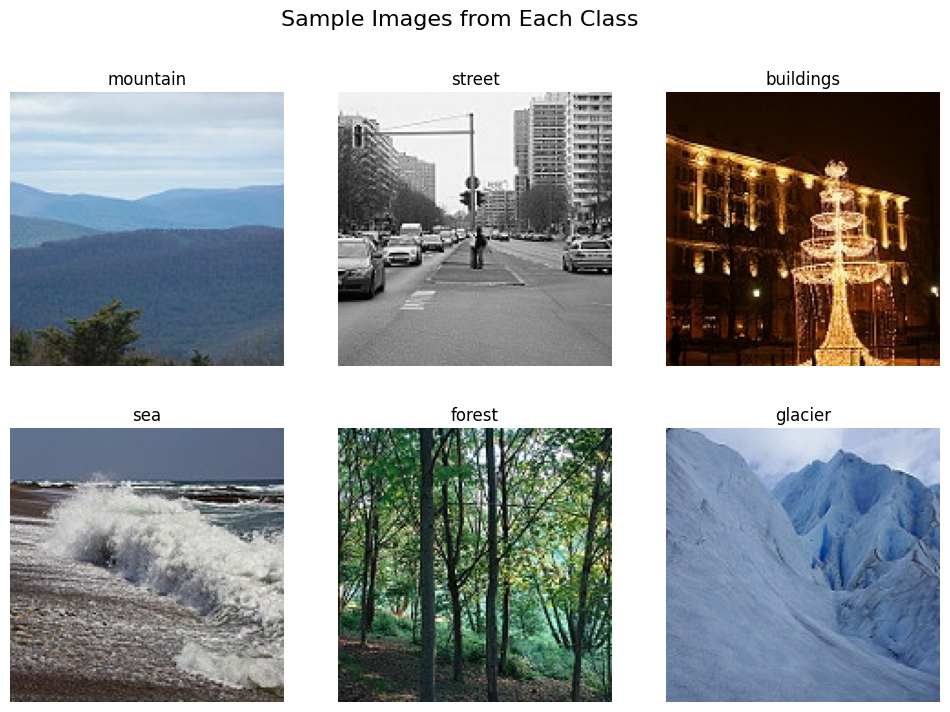

In [6]:
# ===============================
# 🔍 Visualize Sample Images
# ===============================
plt.figure(figsize=(12, 8))

for i, c in enumerate(classes):
    class_dir = os.path.join(train_dir, c)
    img_file = random.choice(os.listdir(class_dir))
    img_path = os.path.join(class_dir, img_file)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(c)
    plt.axis("off")

plt.suptitle("Sample Images from Each Class", fontsize=16)
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


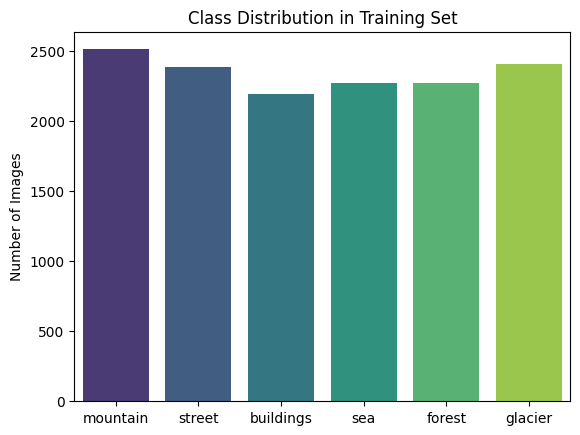

mountain: 2512 images (17.90%)
street: 2382 images (16.97%)
buildings: 2191 images (15.61%)
sea: 2274 images (16.20%)
forest: 2271 images (16.18%)
glacier: 2404 images (17.13%)


In [7]:
# ===============================
# 📊 Class Distribution
# ===============================
counts = [len(os.listdir(os.path.join(train_dir, c))) for c in classes]
total = sum(counts)

sns.barplot(x=classes, y=counts, palette="viridis")
plt.title("Class Distribution in Training Set")
plt.ylabel("Number of Images")
plt.show()

# Print percentage distribution
for c, n in zip(classes, counts):
    print(f"{c}: {n} images ({n/total:.2%})")


In [8]:
# ===============================
# 📏 Image Size Analysis
# ===============================
all_shapes = []
for c in classes:
    cls_dir = os.path.join(train_dir, c)
    for img_file in random.sample(os.listdir(cls_dir), min(20, len(os.listdir(cls_dir)))):  
        # sample subset for efficiency
        img = cv2.imread(os.path.join(cls_dir, img_file))
        if img is not None:
            all_shapes.append(img.shape[:2])

heights, widths = zip(*all_shapes)
print("Height range:", min(heights), "-", max(heights))
print("Width range:", min(widths), "-", max(widths))
print("Most common size:", pd.Series(all_shapes).mode().values)

Height range: 150 - 150
Width range: 150 - 150
Most common size: [(150, 150)]


In [9]:
# ===============================
# 📌 Data Augmentation & Generators
# ===============================

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 🔹 Training Data Generator (with Augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values (0–255 → 0–1)
    rotation_range=25,          # Random rotations
    width_shift_range=0.15,     # Horizontal shift
    height_shift_range=0.15,    # Vertical shift
    zoom_range=0.25,            # Random zoom
    horizontal_flip=True,       # Flip horizontally
    brightness_range=[0.7,1.3], # Random brightness
    validation_split=0.2        # 20% split for validation
)

# 🔹 Validation Data Generator (only normalization)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# 🔹 Test Data Generator (only normalization)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
# ===============================
# 📂 Create Generators
# ===============================

# Training set (with augmentation)
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

# Validation set (no augmentation)
val_gen = val_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

# Test set (from provided test folder)
test_gen = test_datagen.flow_from_directory(
    val_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


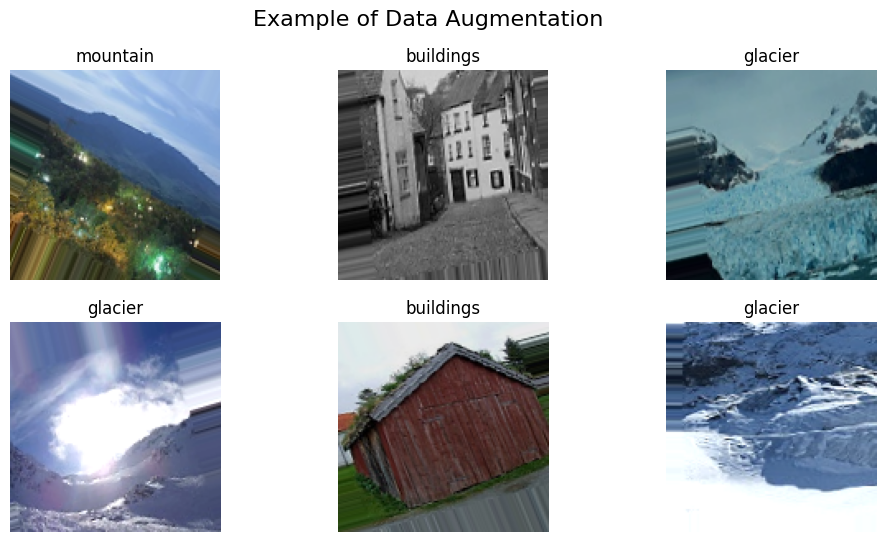

In [10]:
# ===============================
# 📊 Show Augmented Samples
# ===============================

class_names = list(train_gen.class_indices.keys())
print("Classes:", class_names)

images, labels = next(train_gen)

plt.figure(figsize=(12,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

plt.suptitle("Example of Data Augmentation", fontsize=16)
plt.show()

In [11]:
# ===============================
# 📌 Baseline CNN Model
# ===============================

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the baseline CNN architecture
baseline_model = Sequential([
    Input(shape=(128,128,3)),   # Explicit Input layer
    
    # Convolutional Block 1
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    # Convolutional Block 2
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    # Convolutional Block 3
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    # Flatten + Fully Connected Layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),   # Helps prevent overfitting
    
    # Output Layer (6 classes → softmax)
    Dense(6, activation='softmax')
])

# Compile the model
baseline_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
baseline_model.summary()


I0000 00:00:1759146626.350150      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759146626.350961      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,517,574 (24.86 MB)

 Trainable params: 6,517,574 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# ===============================
# 📌 Training Setup
# ===============================
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the baseline model
history_baseline = baseline_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 62s 175ms/step - accuracy: 0.6062 - loss: 1.0220 - val_accuracy: 0.6583 - val_loss: 0.9048
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 60s 172ms/step - accuracy: 0.6547 - loss: 0.9188 - val_accuracy: 0.6933 - val_loss: 0.8460
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 62s 176ms/step - accuracy: 0.7073 - loss: 0.7933 - val_accuracy: 0.7971 - val_loss: 0.6109
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 67s 191ms/step - accuracy: 0.7191 - loss: 0.7612 - val_accuracy: 0.7850 - val_loss: 0.5857
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 67s 191ms/step - accuracy: 0.7375 - loss: 0.7265 - val_accuracy: 0.8039 - val_loss: 0.5504
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 67s 191ms/step - accuracy: 0.7472 - loss: 0.6894 - val_accuracy: 0.8199 - val_loss: 0.5312
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 66s 188ms/step - accuracy: 0.7661 - loss: 0.6548 - val_accuracy: 0.7917 - val_loss: 0.5858
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 63s 181ms/step - accuracy: 0.7629 - loss: 0

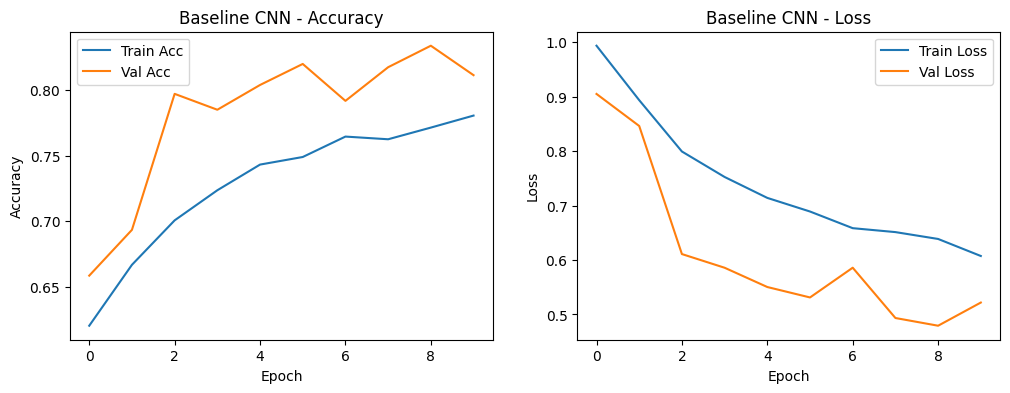

In [14]:
# ===============================
# 📊 Training Curves
# ===============================
def plot_history(history, title="Model Training"):
    """Plot training vs validation accuracy and loss curves."""
    plt.figure(figsize=(12,4))
    
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="Train Acc")
    plt.plot(history.history["val_accuracy"], label="Val Acc")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.legend()
    
    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.legend()
    
    plt.show()

# Plot baseline CNN performance
plot_history(history_baseline, title="Baseline CNN")

In [11]:
# ===============================
# 📌 Transfer Learning with VGG16
# ===============================

from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

num_classes = 6

# Load pre-trained VGG16 without the top classifier
base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(128,128,3)
)

# Freeze all layers initially (train only the new head)
for l in base_model.layers:
    l.trainable = False

# Build the model
inputs = layers.Input(shape=(128,128,3))
x = base_model(inputs, training=False)
x = layers.Flatten()(x)
x = layers.Dense(
    512, activation="relu", 
    kernel_regularizer=regularizers.l2(1e-4)
)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

vgg_model = models.Model(inputs, outputs)

# Compile model
vgg_model.compile(
    optimizer=Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

vgg_model.summary()

I0000 00:00:1759179840.503130      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759179840.503915      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,912,582 (72.15 MB)

 Trainable params: 4,197,894 (16.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
# ===============================
# 📌 Callbacks
# ===============================
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1)
ckp = ModelCheckpoint("vgg16_best.h5", monitor="val_loss", save_best_only=True)

In [13]:
# ===============================
# 📌 Train Top Layers Only
# ===============================
history_vgg_head = vgg_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=[es, rlr, ckp],
    verbose=1
)

plot_history(history_vgg_head, title="VGG16 (Frozen Base)")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1759179845.280162     124 service.cc:148] XLA service 0x7f9a1400d7e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759179845.281294     124 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1759179845.281318     124 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1759179845.690190     124 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/351 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - accuracy: 0.1875 - loss: 2.1604

I0000 00:00:1759179851.579215     124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


351/351 ━━━━━━━━━━━━━━━━━━━━ 85s 217ms/step - accuracy: 0.6190 - loss: 1.0776 - val_accuracy: 0.8495 - val_loss: 0.5020 - learning_rate: 1.0000e-04
Epoch 2/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 67s 191ms/step - accuracy: 0.7820 - loss: 0.6462 - val_accuracy: 0.8588 - val_loss: 0.4615 - learning_rate: 1.0000e-04
Epoch 3/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 67s 192ms/step - accuracy: 0.8075 - loss: 0.5895 - val_accuracy: 0.8409 - val_loss: 0.4645 - learning_rate: 1.0000e-04
Epoch 4/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 67s 192ms/step - accuracy: 0.8137 - loss: 0.5666 - val_accuracy: 0.8559 - val_loss: 0.4414 - learning_rate: 1.0000e-04
Epoch 5/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - accuracy: 0.8210 - loss: 0.5459 - val_accuracy: 0.8655 - val_loss: 0.4273 - learning_rate: 1.0000e-04
Epoch 6/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 69s 195ms/step - accuracy: 0.8341 - loss: 0.5116 - val_accuracy: 0.8616 - val_loss: 0.4371 - learning_rate: 1.0000e-04
Epoch 7/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 69s 197ms/step - 

KeyboardInterrupt: 

In [14]:
# ===============================
# 📌 Fine-Tuning Last Convolution Block
# ===============================
# Unfreeze last 4 layers of VGG16 for fine-tuning
for l in base_model.layers:
    l.trainable = False
for l in base_model.layers[-4:]:
    l.trainable = True

# Recompile with lower learning rate
vgg_model.compile(
    optimizer=Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Fine-tuning
history_vgg_ft = vgg_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[es, rlr],
    verbose=1
)

plot_history(history_vgg_ft, title="VGG16 Fine-Tuned")

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 78s 206ms/step - accuracy: 0.8544 - loss: 0.4488 - val_accuracy: 0.8845 - val_loss: 0.3777 - learning_rate: 1.0000e-05
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 69s 198ms/step - accuracy: 0.8730 - loss: 0.4114 - val_accuracy: 0.8784 - val_loss: 0.3793 - learning_rate: 1.0000e-05
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 69s 196ms/step - accuracy: 0.8803 - loss: 0.3874 - val_accuracy: 0.8798 - val_loss: 0.3643 - learning_rate: 1.0000e-05
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 69s 196ms/step - accuracy: 0.8844 - loss: 0.3608 - val_accuracy: 0.9030 - val_loss: 0.3248 - learning_rate: 1.0000e-05
Epoch 5/10
 28/351 ━━━━━━━━━━━━━━━━━━━━ 58s 182ms/step - accuracy: 0.8889 - loss: 0.3443

KeyboardInterrupt: 

94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step
📊 Classification Report
              precision    recall  f1-score   support

   buildings      0.860     0.931     0.895       437
      forest      0.981     0.985     0.983       474
     glacier      0.800     0.873     0.835       553
    mountain      0.870     0.781     0.823       525
         sea      0.922     0.884     0.903       510
      street      0.930     0.904     0.917       501

    accuracy                          0.890      3000
   macro avg      0.894     0.893     0.893      3000
weighted avg      0.892     0.890     0.890      3000



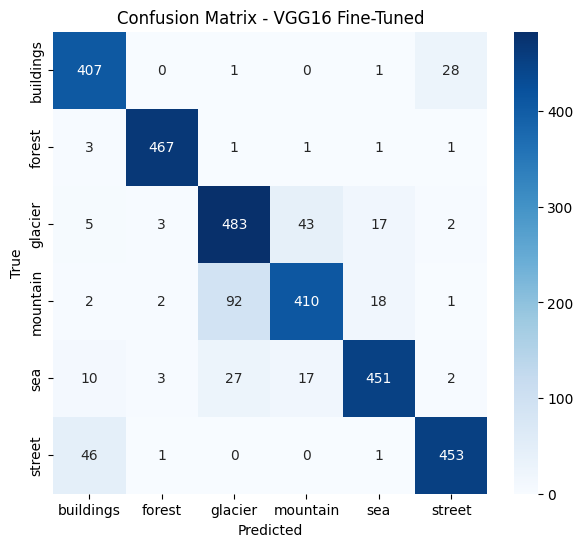

In [15]:
# ===============================
# 📌 Model Evaluation on Test Data
# ===============================

# Reset test generator for clean predictions
test_gen.reset()

# Predict class probabilities
probs = vgg_model.predict(test_gen, verbose=1)
y_pred = np.argmax(probs, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

# Classification Report
print("📊 Classification Report")
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - VGG16 Fine-Tuned")
plt.show()

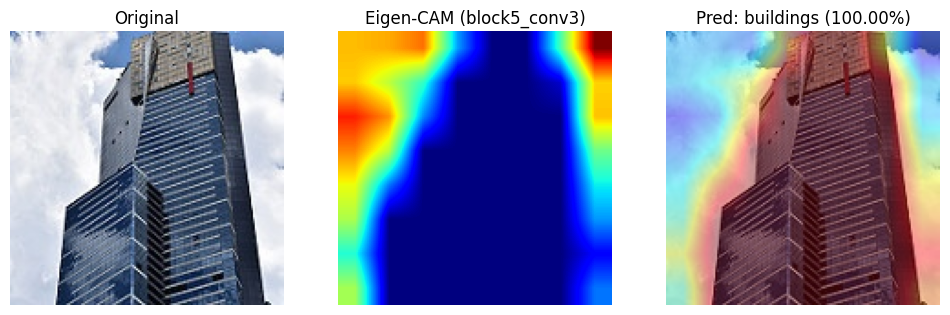

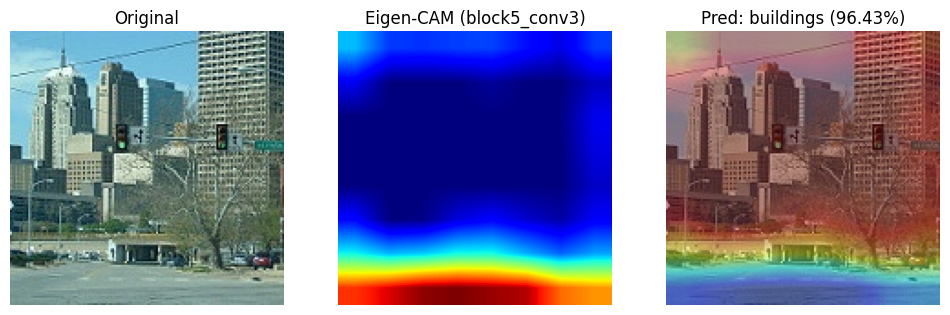

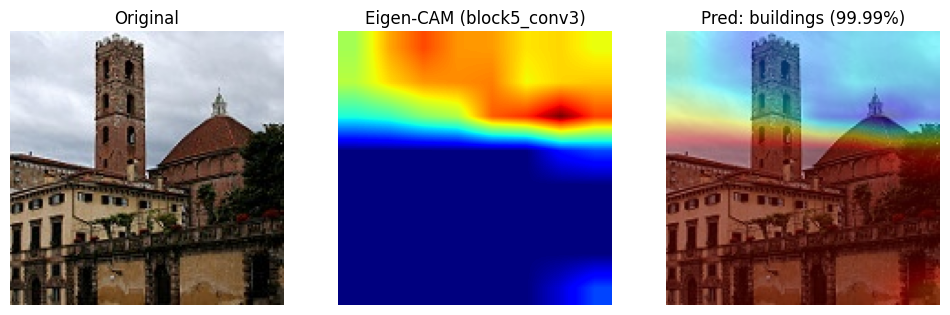

In [16]:
# ===============================
# 📌 Grad-CAM / Eigen-CAM Visualization
# ===============================

def show_eigencam(generator, idx=0, target_layer_name="block5_conv3", input_size=(128,128)):
    """
    Visualize class activation map (Eigen-CAM) for a given image.
    
    Args:
        generator : Keras DirectoryIterator (test_gen)
        idx       : Index of the image inside generator
        target_layer_name : Name of target conv layer in VGG16
        input_size: Input size used for resizing (default 128x128)
    """
    # Load image
    img_path = generator.filepaths[idx]
    img_bgr  = cv2.imread(img_path)
    if img_bgr is None:
        raise RuntimeError(f"Image could not be read: {img_path}")
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, input_size)
    x = np.expand_dims(img_resized/255.0, axis=0)  

    # Get the convolutional block from VGG16
    try:
        vgg_block = vgg_model.get_layer("vgg16")
    except ValueError:
        vgg_block = base_model

    feature_extractor = tf.keras.models.Model(
        inputs=vgg_block.input,
        outputs=vgg_block.get_layer(target_layer_name).output
    )

    # Extract feature maps
    feature_maps = feature_extractor(x, training=False).numpy()[0]  # [H, W, C]

    # Eigen-CAM: PCA first principal component
    H, W, C = feature_maps.shape
    reshaped = feature_maps.reshape((-1, C))
    reshaped_centered = reshaped - reshaped.mean(axis=0, keepdims=True)
    _, _, vh = np.linalg.svd(reshaped_centered, full_matrices=False)
    principal = vh[0]
    cam = np.dot(reshaped, principal).reshape(H, W)

    # Normalize CAM
    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)

    # Resize & colorize
    heatmap = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

    # Prediction
    probs = vgg_model.predict(x, verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    pred_name = class_names[pred_idx] if pred_idx < len(class_names) else str(pred_idx)
    pred_conf = float(probs[pred_idx])

    # Overlay heatmap on image
    superimposed = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

    # Plot
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img); plt.axis("off"); plt.title("Original")
    plt.subplot(1,3,2); plt.imshow(heatmap, cmap="jet"); plt.axis("off"); plt.title(f"Eigen-CAM ({target_layer_name})")
    plt.subplot(1,3,3); plt.imshow(superimposed); plt.axis("off")
    plt.title(f"Pred: {pred_name} ({pred_conf:.2%})")
    plt.show()

# Example usage: visualize Eigen-CAM on first 3 test images
for idx in range(3):
    show_eigencam(test_gen, idx=idx, target_layer_name="block5_conv3")

In [ ]:
# ===============================
# 📌 Hyperparameter Tuning with Keras Tuner
# ===============================

import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers, regularizers

num_classes = 6
input_shape = (128,128,3)

def build_model(hp):
    """
    Build a CNN model with hyperparameters defined by Keras Tuner.
    """
    model = keras.Sequential()

    # 🔹 Convolutional Blocks
    for i in range(hp.Int("conv_blocks", 2, 4, default=3)):
        model.add(layers.Conv2D(
            filters=hp.Choice(f"filters_{i}", [32, 64, 128]),
            kernel_size=hp.Choice(f"kernel_size_{i}", [3, 5]),
            activation="relu",
            padding="same",
            kernel_regularizer=regularizers.l2(1e-4),
            input_shape=input_shape if i == 0 else None
        ))
        model.add(layers.MaxPooling2D(pool_size=(2,2)))

    # 🔹 Dense Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Choice("dense_units", [128, 256, 512]),
        activation="relu",
        kernel_regularizer=regularizers.l2(1e-4)
    ))
    model.add(layers.Dropout(hp.Float("dropout", 0.3, 0.6, step=0.1, default=0.5)))

    # 🔹 Output Layer
    model.add(layers.Dense(num_classes, activation="softmax"))

    # 🔹 Optimizer & Learning Rate
    hp_learning_rate = hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])
    hp_optimizer = hp.Choice("optimizer", ["adam", "rmsprop", "sgd"])

    if hp_optimizer == "adam":
        optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)
    elif hp_optimizer == "rmsprop":
        optimizer = keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
    else:
        optimizer = keras.optimizers.SGD(learning_rate=hp_learning_rate, momentum=0.9)

    # Compile
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [23]:
# ===============================
# 🔍 Run Hyperparameter Search
# ===============================
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    directory="tuner_dir",
    project_name="cnn_hyperopt"
)

tuner.search(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)],
    verbose=1
)

# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("📊 Selected Hyperparameters:")
print(f"Conv Blocks: {best_hps.get('conv_blocks')}")
for i in range(best_hps.get('conv_blocks')):
    print(f"Filters {i}: {best_hps.get(f'filters_{i}')}, Kernel: {best_hps.get(f'kernel_size_{i}')}")
print(f"Dense Units: {best_hps.get('dense_units')}")
print(f"Dropout: {best_hps.get('dropout')}")
print(f"Optimizer: {best_hps.get('optimizer')}, LR: {best_hps.get('learning_rate')}")

Trial 10 Complete [00h 10m 20s]
val_accuracy: 0.7375178337097168

Best val_accuracy So Far: 0.8120542168617249
Total elapsed time: 01h 43m 03s
📊 Selected Hyperparameters:
Conv Blocks: 3
Filters 0: 64, Kernel: 5
Filters 1: 64, Kernel: 5
Filters 2: 128, Kernel: 3
Dense Units: 256
Dropout: 0.3
Optimizer: adam, LR: 0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 69s 185ms/step - accuracy: 0.7614 - loss: 0.6980 - val_accuracy: 0.7846 - val_loss: 0.6275
Epoch 2/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 63s 180ms/step - accuracy: 0.7713 - loss: 0.6846 - val_accuracy: 0.7643 - val_loss: 0.6889
Epoch 3/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 63s 178ms/step - accuracy: 0.7736 - loss: 0.6585 - val_accuracy: 0.8096 - val_loss: 0.5979
Epoch 4/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 63s 178ms/step - accuracy: 0.7798 - loss: 0.6538 - val_accuracy: 0.8071 - val_loss: 0.5917
Epoch 5/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 63s 179ms/step - accuracy: 0.7790 - loss: 0.6619 - val_accuracy: 0.8149 - val_loss: 0.5783
Epoch 6/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 63s 181ms/step - accuracy: 0.7924 - loss: 0.6285 - val_accuracy: 0.8010 - val_loss: 0.6150
Epoch 7/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 65s 185ms/step - accuracy: 0.7951 - loss: 0.6239 - val_accuracy: 0.8363 - val_loss: 0.5233
Epoch 8/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 64s 181ms/step - accuracy: 0.8029 - loss: 0

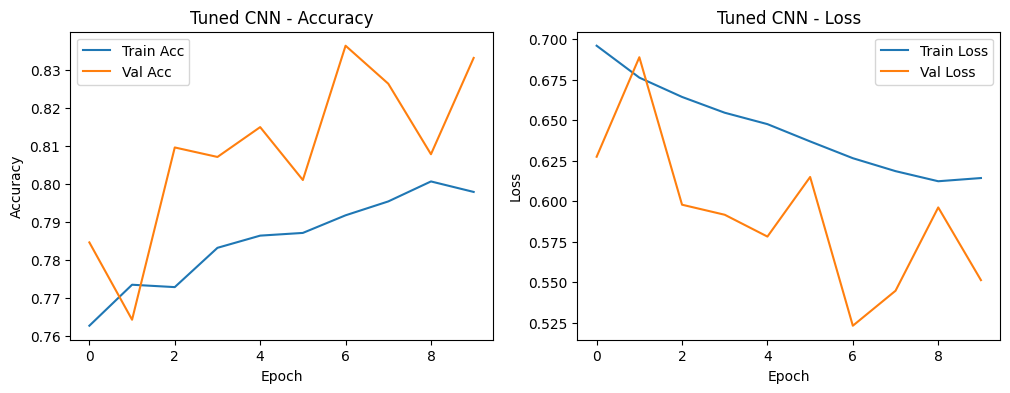

In [24]:
# ===============================
# 📌 Train Best Model
# ===============================
best_model = tuner.get_best_models(num_models=1)[0]

history_tuned = best_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)],
    verbose=1
)

plot_history(history_tuned, title="Tuned CNN")


94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.8525 - loss: 0.4879
✅ Final Test Accuracy: 0.8260, Test Loss: 0.5649
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step
📊 Classification Report - Tuned CNN
              precision    recall  f1-score   support

   buildings       0.70      0.87      0.77       437
      forest       0.92      0.97      0.94       474
     glacier       0.89      0.70      0.78       553
    mountain       0.78      0.80      0.79       525
         sea       0.85      0.82      0.84       510
      street       0.84      0.83      0.84       501

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000



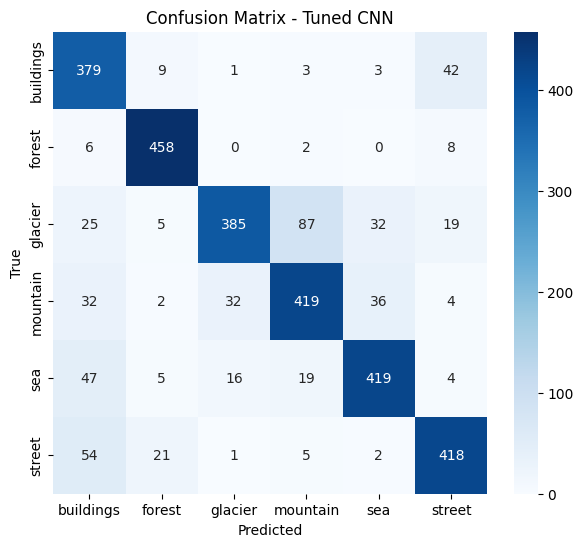

In [25]:
# ===============================
# 📌 Final Evaluation on Test Set
# ===============================
test_loss, test_acc = best_model.evaluate(test_gen, verbose=1)
print(f"✅ Final Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# Predictions
y_pred = best_model.predict(test_gen)
y_pred_classes = y_pred.argmax(axis=1)
y_true = test_gen.classes

print("📊 Classification Report - Tuned CNN")
print(classification_report(y_true, y_pred_classes, target_names=list(test_gen.class_indices.keys())))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Tuned CNN")
plt.show()

In [17]:
# ===============================
# 📌 Save the Best Model
# ===============================
vgg_model.save("intel_cnn_best.h5")
print("✅ Model saved as intel_cnn_best.h5")

# ===============================
# 📌 Load Model Later
# ===============================
from tensorflow.keras.models import load_model

loaded_model = load_model("intel_cnn_best.h5")
print("✅ Model loaded successfully")

# Run inference on an unseen image
import cv2
import numpy as np

def predict_image(model, img_path, target_size=(128,128)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, target_size)
    x = np.expand_dims(img_resized/255.0, axis=0)  # normalize & batch

    probs = model.predict(x)[0]
    pred_idx = np.argmax(probs)
    pred_class = list(train_gen.class_indices.keys())[pred_idx]
    confidence = probs[pred_idx]

    return pred_class, confidence

# Example: pick a random test image
sample_path = test_gen.filepaths[10]
pred_class, confidence = predict_image(loaded_model, sample_path)
print(f"Predicted: {pred_class} ({confidence:.2%})")


✅ Model saved as intel_cnn_best.h5
✅ Model loaded successfully
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
Predicted: buildings (98.11%)
